<h1>Data Challenge: Praxal Patel

<h2> Email: psp334@nyu.edu

In [103]:
# All the required imports

In [1]:
import pandas as pd
import numpy as np

import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True) 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Markdown
def bold(string):
    display(Markdown(string))



from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

from sklearn.metrics import r2_score


Using TensorFlow backend.


In [2]:
df = pd.read_csv('sample_data.csv')

In [3]:
df.head()

,entity,formattype,fromdate,titlecount,titles,todate,author,amazontotalreviews,minappleprice,amazontotalrevenue,...,lumpedpreorderrevenue,amazonsoldunits,amazonpreordersubscriptionrevenue,preordersubscriptionunits,amazonpreordersalesrevenue,maxappleprice,pagelength,pricewassetbypublisher,barnesandnobledistributor,appledistributor
0,Alone in the dark,print,20170418,1,"{'amazontotalreviews': 306, 'minappleprice': 0...",20170419,Frith Banbury,306.0,0,0,...,0,6,0,0,0,0,NaN,NaN,NaN,NaN
1,Alone in the dark,print,20170419,1,"{'amazontotalreviews': 306, 'minappleprice': 0...",20170420,Frith Banbury,306.0,0,702,...,0,7,0,0,0,0,NaN,NaN,NaN,NaN
2,Alone in the dark,print,20170420,1,"{'amazontotalreviews': 306, 'minappleprice': 0...",20170421,Frith Banbury,306.0,0,4914,...,0,7,0,0,0,0,NaN,NaN,NaN,NaN
3,Alone in the dark,print,20170421,1,"{'amazontotalreviews': 306, 'minappleprice': 0...",20170422,Frith Banbury,306.0,0,4212,...,0,6,0,0,0,0,NaN,NaN,NaN,NaN
4,Alone in the dark,print,20170422,1,"{'amazontotalreviews': 306, 'minappleprice': 0...",20170423,Frith Banbury,306.0,0,702,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN


In [4]:
#Converting to TimeStamp
df['fromdate']= df['fromdate'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df['month']= df['fromdate'].apply(lambda x: x.month)
df['year'] = df['fromdate'].apply(lambda x: x.year)
df['week'] = df['fromdate'].apply(lambda x: x.strftime("%a"))

In [5]:
df['entity'].unique()

array(['Alone in the dark', 'The Walking Dead'], dtype=object)

In [6]:
df.groupby(['entity'])['fromdate'].count()

entity
Alone in the dark    3040
The Walking Dead     3499
Name: fromdate, dtype: int64

In [7]:
df.groupby(['entity'])['totalrevenue'].sum()

entity
Alone in the dark     10302489
The Walking Dead     114246963
Name: totalrevenue, dtype: int64

In [8]:
df.groupby(['entity','formattype'])['fromdate'].count()

entity             formattype
Alone in the dark  audio          621
                   ebook          887
                   print         1532
The Walking Dead   audio          847
                   ebook          874
                   print         1778
Name: fromdate, dtype: int64

In [9]:
df.groupby(['entity','formattype'])['totalrevenue'].sum()

entity             formattype
Alone in the dark  audio          2066812
                   ebook          5966299
                   print          2269378
The Walking Dead   audio         28402266
                   ebook         15669751
                   print         70174946
Name: totalrevenue, dtype: int64

In [10]:
df.groupby(['entity','formattype','formats'])['fromdate'].count()

entity             formattype  formats                             
Alone in the dark  audio       Audible                                  19
                               Audible Audiobook                       299
                               Audible Book                             12
                               Audiobook                               291
                   ebook       Kindle Edition                           19
                               Kindle Edition,NOOK Book                863
                               NOOK Book                                 5
                   print       Audio CD                                789
                               Hardcover                               248
                               Mass Market Paperback                   477
                               Paperback                                18
The Walking Dead   audio       Audible                                  27
                               A

In [11]:
df.groupby(['entity','formattype','formats'])['totalrevenue'].sum()

entity             formattype  formats                             
Alone in the dark  audio       Audible                                    85835
                               Audible Audiobook                        1019405
                               Audible Book                               35792
                               Audiobook                                 925780
                   ebook       Kindle Edition                             45435
                               Kindle Edition,NOOK Book                 5899195
                               NOOK Book                                  21669
                   print       Audio CD                                 1737698
                               Hardcover                                 157396
                               Mass Market Paperback                     374284
                               Paperback                                      0
The Walking Dead   audio       Audible              

In [12]:
df['YearMonth'] = pd.to_datetime(df['fromdate']).apply(lambda x: '{year}_{month}'.format(year=x.year, month=x.month if x.month>=10 else "0"+str(x.month)))


In [13]:
df_alone_in_the_dark = df[df['entity'] == 'Alone in the dark']
df_walking_dead = df[df['entity'] == 'The Walking Dead']

We can also see that total revenue is equal to the sum of sales revenue and subscription revenue

In [49]:
(df['totalrevenue'] - df['salesrevenue'] - df['subscriptionrevenue']).unique()

array([0])

Thus, it seems plausible to use the total revenue for prediction and other exploratory analysis. In addition to that the subsequent plots can be utilized for columns like amazon average ratings, delving more into the changing the prices of the items and what factors drive those changes, etc.

<h2> Alone in the Dark

In [15]:
df_alone_in_the_dark_print = df_alone_in_the_dark[df_alone_in_the_dark['formattype'] == 'print']
df_alone_in_the_dark_ebook = df_alone_in_the_dark[df_alone_in_the_dark['formattype'] == 'ebook']
df_alone_in_the_dark_audio = df_alone_in_the_dark[df_alone_in_the_dark['formattype'] == 'audio']

In [16]:
df_alone_in_the_dark_print_total = df_alone_in_the_dark_print.groupby(['fromdate'],as_index=False).totalrevenue.sum()
df_alone_in_the_dark_ebook_total = df_alone_in_the_dark_ebook.groupby(['fromdate'],as_index=False).totalrevenue.sum()
df_alone_in_the_dark_audio_total = df_alone_in_the_dark_audio.groupby(['fromdate'],as_index=False).totalrevenue.sum()

In [17]:
df_alone_in_the_dark_print_monthly = df_alone_in_the_dark_print.groupby(['month'],as_index=False).totalrevenue.sum()
df_alone_in_the_dark_ebook_monthly = df_alone_in_the_dark_ebook.groupby(['month'],as_index=False).totalrevenue.sum()
df_alone_in_the_dark_audio_monthly = df_alone_in_the_dark_audio.groupby(['month'],as_index=False).totalrevenue.sum()


In [18]:
alone_in_the_dark_print_monthly = go.Bar(
                x = df_alone_in_the_dark_print_monthly['month'],
                y = df_alone_in_the_dark_print_monthly['totalrevenue'],
                name = "print", opacity = 0.7,
                marker = dict(color = 'rgb(200, 200, 0)',
                              line=dict(color='rgb(200, 200, 0)',width=1.5)))
alone_in_the_dark_audio_monthly = go.Bar(
                x = df_alone_in_the_dark_audio_monthly['month'],
                y = df_alone_in_the_dark_audio_monthly['totalrevenue'],
                name = "audio", opacity = 0.7,
                marker = dict(color = 'rgb(255, 0, 0)',
                              line=dict(color='rgb(255,0,0)',width=1.5)))

alone_in_the_dark_ebook_monthly = go.Bar(
                x = df_alone_in_the_dark_ebook_monthly['month'],
                y = df_alone_in_the_dark_ebook_monthly['totalrevenue'],
                name = "ebook", opacity = 0.7,
                marker = dict(color = 'rgb(0, 0, 255)',
                              line=dict(color='rgb(0, 0, 255)',width=1.5)))


layout = go.Layout(hovermode= 'closest', title = 'Alone in the dark monthly sales' , xaxis = dict(title = 'Month'), yaxis = dict(title = 'Total Revenue'))
fig = go.Figure(data =  [alone_in_the_dark_audio_monthly,alone_in_the_dark_ebook_monthly,alone_in_the_dark_print_monthly], layout = layout)
fig.show()


In [19]:
df_alone_in_the_dark_print_month_year = df_alone_in_the_dark_print.groupby(['YearMonth'],as_index=False).totalrevenue.sum()
df_alone_in_the_dark_ebook_month_year = df_alone_in_the_dark_ebook.groupby(['YearMonth'],as_index=False).totalrevenue.sum()
df_alone_in_the_dark_audio_month_year = df_alone_in_the_dark_audio.groupby(['YearMonth'],as_index=False).totalrevenue.sum()


In [20]:
df_alone_in_the_dark_year_month = df_alone_in_the_dark.groupby(['YearMonth'],as_index=False).totalrevenue.sum()
df_walking_dead_year_month = df_walking_dead.groupby(['YearMonth'],as_index=False).totalrevenue.sum()

In [21]:
trace_alone_in_the_dark = go.Scatter(
                x = df_alone_in_the_dark_year_month["YearMonth"],
                y = df_alone_in_the_dark_year_month['totalrevenue'],
                name = "Alone in the dark",
                marker = dict(color = 'rgb(255, 0, 0)',
                              line=dict(color='rgb(255,0,0)',width=2)))

layout = go.Layout(hovermode= 'closest', title = 'Alone in the dark sales' , xaxis = dict(title = 'Year_Month'), yaxis = dict(title = 'Total Revenue'))
fig = go.Figure(data =  [trace_alone_in_the_dark], layout = layout)
fig.show()

<h2> The Walking Dead

In [22]:
trace_walking_dead = go.Scatter(
                x = df_walking_dead_year_month["YearMonth"],
                y = df_walking_dead_year_month['totalrevenue'],
                name = "The Walking Dead",
                marker = dict(color = 'rgb(0, 0, 255)',
                              line=dict(color='rgb(0,0,255)',width=2)))

layout = go.Layout(hovermode= 'closest', title = 'The Walking Dead sales' , xaxis = dict(title = 'Year_Month'), yaxis = dict(title = 'Total Revenue'))
fig = go.Figure(data =  [trace_walking_dead], layout = layout)
fig.show()

External Market Analysis: The sales of the Walking Dead seem to peak mostly before and during the airing of the series. This can be confirmed by looking at the preorder sales of the Walking Dead (687 units)

In [50]:
df_walking_dead_print = df_walking_dead[df_walking_dead['formattype'] == 'print']
df_walking_dead_ebook = df_walking_dead[df_walking_dead['formattype'] == 'ebook']
df_walking_dead_audio = df_walking_dead[df_walking_dead['formattype'] == 'audio']

In [51]:
df_walking_dead_print_monthly = df_walking_dead_print.groupby(['month'],as_index=False).totalrevenue.sum()
df_walking_dead_ebook_monthly = df_walking_dead_ebook.groupby(['month'],as_index=False).totalrevenue.sum()
df_walking_dead_audio_monthly = df_walking_dead_audio.groupby(['month'],as_index=False).totalrevenue.sum()


In [52]:
df_walking_dead_print_monthly = go.Bar(
                x = df_walking_dead_print_monthly['month'],
                y = df_walking_dead_print_monthly['totalrevenue'],
                name = "print", opacity = 0.7,
                marker = dict(color = 'rgb(200, 200, 0)',
                              line=dict(color='rgb(200, 200, 0)',width=1.5)))
df_walking_dead_audio_monthly = go.Bar(
                x = df_walking_dead_audio_monthly['month'],
                y = df_walking_dead_audio_monthly['totalrevenue'],
                name = "audio", opacity = 0.7,
                marker = dict(color = 'rgb(255, 0, 0)',
                              line=dict(color='rgb(255,0,0)',width=1.5)))

df_walking_dead_ebook_monthly = go.Bar(
                x = df_walking_dead_ebook_monthly['month'],
                y = df_walking_dead_ebook_monthly['totalrevenue'],
                name = "ebook", opacity = 0.7,
                marker = dict(color = 'rgb(0, 0, 255)',
                              line=dict(color='rgb(0, 0, 255)',width=1.5)))


layout = go.Layout(hovermode= 'closest', title = 'The Walking Dead monthly sales' , xaxis = dict(title = 'Month'), yaxis = dict(title = 'Total Revenue'))
fig = go.Figure(data =  [df_walking_dead_audio_monthly,df_walking_dead_ebook_monthly,df_walking_dead_print_monthly], layout = layout)
fig.show()


The overall sales of Walking Dead seems to increase in the months of June-August. The printed copies dominate the total revenue for The Walking Dead. As discussed in the previous analysis, Paperback and Hardcover dominated the revenue share for "The Walking Dead"

In [43]:
layout = go.Layout(hovermode= 'closest', title = 'The Walking Dead sales vs Alone in the dark' , xaxis = dict(title = 'Year_Month'), yaxis = dict(title = 'Total Revenue'))
fig = go.Figure(data =  [trace_alone_in_the_dark,trace_walking_dead], layout = layout)
fig.show()

From the above plot, we can observe that the total revenues gained from both the entities are disparate and thus for further analysis, I have separated both the entities

<h2>Alone in the dark

In [24]:
df_alone_in_the_dark_monthly = df_alone_in_the_dark.groupby(['month'],as_index=False).totalrevenue.sum()
df_alone_in_the_dark_weekday = df_alone_in_the_dark.groupby(['week'],as_index=False).totalrevenue.sum()

In [25]:
df_alone_in_the_dark_print_weekday = df_alone_in_the_dark_print.groupby(['week'],as_index=False).totalrevenue.sum()
df_alone_in_the_dark_ebook_weekday = df_alone_in_the_dark_ebook.groupby(['week'],as_index=False).totalrevenue.sum()
df_alone_in_the_dark_audio_weekday = df_alone_in_the_dark_audio.groupby(['week'],as_index=False).totalrevenue.sum()


In [26]:
df_alone_in_the_dark_monthly

,month,totalrevenue
0,1,652274
1,2,541800
2,3,525252
3,4,846171
4,5,1231394
5,6,1220974
6,7,1291442
7,8,1116275
8,9,817059
9,10,883074


In [27]:
trace1 = go.Bar(
                x = df_alone_in_the_dark_print['fromdate'],
                y = df_alone_in_the_dark_print['totalrevenue'],
                name = "print", opacity = 0.7,
                marker = dict(color = 'rgb(200, 200, 0)',
                             line=dict(color='rgb(200, 200, 0)',width=1.5))
                )

trace2 = go.Bar(
                x = df_alone_in_the_dark_ebook['fromdate'],
                y = df_alone_in_the_dark_ebook['totalrevenue'],
                name = "ebook", opacity = 0.7,
                marker = dict(color = 'rgb(0, 0, 255)',
                              line=dict(color='rgb(0, 0, 255)',width=1.5)))

trace3 = go.Bar(
                x = df_alone_in_the_dark_audio['fromdate'],
                y = df_alone_in_the_dark_audio['totalrevenue'],
                name = "audio", opacity = 0.7,
                marker = dict(color = 'rgb(255, 0, 0)',
                              line=dict(color='rgb(255,0,0)',width=1.5)))

layout = go.Layout(hovermode= 'closest', title = 'Alone in the dark sales' , xaxis = dict(title = 'Year'), yaxis = dict(title = 'Total Revenue'))
fig = go.Figure(data =  [trace2,trace3,trace1], layout = layout)
fig.show()


Important Points:

Audio sales for 'Alone in the dark' were not as consistent as it's print and ebook counterparts. 
Ebook sales seem to dominate the shares in the revenue.
Print sales were consistent but the peaks were more or less seasonal.

From the plot, I observed that there was no revenue generated through audio sales between June 2018 and mid-July 2018. To further validate my observation, I plotted the following graph.

In [46]:
df_alone_in_the_dark_print = df_alone_in_the_dark_print[df_alone_in_the_dark_print['fromdate'] > '2018-05-15']
df_alone_in_the_dark_print = df_alone_in_the_dark_print[df_alone_in_the_dark_print['fromdate'] < '2018-07-20']


df_alone_in_the_dark_ebook = df_alone_in_the_dark_ebook[df_alone_in_the_dark_ebook['fromdate'] > '2018-05-15']
df_alone_in_the_dark_ebook = df_alone_in_the_dark_ebook[df_alone_in_the_dark_ebook['fromdate'] < '2018-07-20']


df_alone_in_the_dark_audio = df_alone_in_the_dark_audio[df_alone_in_the_dark_audio['fromdate'] > '2018-05-15']
df_alone_in_the_dark_audio = df_alone_in_the_dark_audio[df_alone_in_the_dark_audio['fromdate'] < '2018-07-20']




trace1 = go.Bar(
                x = df_alone_in_the_dark_print['fromdate'],
                y = df_alone_in_the_dark_print['totalrevenue'],
                name = "print", opacity = 0.7,
                marker = dict(color = 'rgb(200, 200, 0)',
                             line=dict(color='rgb(200, 200, 0)',width=1.5))
                )

trace2 = go.Bar(
                x = df_alone_in_the_dark_ebook['fromdate'],
                y = df_alone_in_the_dark_ebook['totalrevenue'],
                name = "ebook", opacity = 0.7,
                marker = dict(color = 'rgb(0, 0, 255)',
                              line=dict(color='rgb(0, 0, 255)',width=1.5)))

trace3 = go.Bar(
                x = df_alone_in_the_dark_audio['fromdate'],
                y = df_alone_in_the_dark_audio['totalrevenue'],
                name = "audio", opacity = 0.7,
                marker = dict(color = 'rgb(255, 0, 0)',
                              line=dict(color='rgb(255,0,0)',width=1.5)))

layout = go.Layout(hovermode= 'closest', title = 'Alone in the dark sales' , xaxis = dict(title = 'Year'), yaxis = dict(title = 'Total Revenue'))
fig = go.Figure(data =  [trace2,trace3,trace1], layout = layout)
fig.show()


<h2> Revenue Forecasting for Alone in the Dark using LSTM:

In [29]:
df_alone_in_the_dark_forecast = df_alone_in_the_dark[['fromdate', 'totalrevenue']]

In [30]:
df_alone_in_the_dark_forecast

,fromdate,totalrevenue
0,2017-04-18,0
1,2017-04-19,702
2,2017-04-20,4914
3,2017-04-21,4212
4,2017-04-22,702
...,...,...
3035,2019-08-22,1795
3036,2019-08-23,0
3037,2019-08-24,0
3038,2019-08-25,0


<h3> Checking for outliers

In [31]:
df_alone_in_the_dark_forecast.describe()

,totalrevenue
count,3040.000000
mean,3388.976645
std,3593.706625
min,0.000000
25%,719.000000
50%,2101.500000
75%,4995.000000
max,23766.000000


In [32]:
df_alone_in_the_dark_forecast[df_alone_in_the_dark_forecast['totalrevenue'] > 15000]

,fromdate,totalrevenue
1582,2017-05-24,18174
1583,2017-05-25,23766
1584,2017-05-26,18873
1585,2017-05-27,17475
1586,2017-05-28,18174
1612,2017-06-23,16776
1617,2017-06-28,15378
1618,2017-06-29,15378
1622,2017-07-03,17475
1626,2017-07-07,16776


The entries with revenue 15000 or more were consistent for 3 to 4 days and should not be considered outliers in our case.

For time series forecasting data, when the data is not stationary we tend to opt for difference in consecutive values.

,fromdate,totalrevenue,totalrevenue_diff
0,2017-04-18,0,NaN
1,2017-04-19,702,702.0
2,2017-04-20,4914,4212.0
3,2017-04-21,4212,-702.0
4,2017-04-22,702,-3510.0


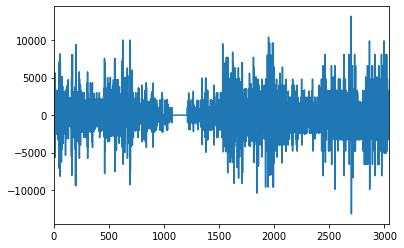

In [33]:
df_alone_in_the_dark_forecast['totalrevenue_diff'] = df_alone_in_the_dark_forecast['totalrevenue'] - df_alone_in_the_dark_forecast['totalrevenue'].shift(1)
df_alone_in_the_dark_forecast['totalrevenue_diff'].plot()
df_alone_in_the_dark_forecast.head()

In [34]:
df_alone_in_the_dark_forecast = df_alone_in_the_dark_forecast.loc[1:,:]

In [35]:
df_alone_in_the_dark_forecast['fromdate'] = df_alone_in_the_dark_forecast['fromdate'].dt.strftime('%Y%m%d')

In [36]:
dataset = df_alone_in_the_dark_forecast.values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 7
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [37]:

model = Sequential()
model.add(LSTM(4,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs = 32, batch_size = 13, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1, shuffle=False)

model.summary()

Train on 7285 samples, validate on 1816 samples
Epoch 1/32
7285/7285 [==============================] - 1s 136us/step - loss: 0.0982 - val_loss: 3.9697e-06
Epoch 2/32
7285/7285 [==============================] - 1s 74us/step - loss: 1.4167e-07 - val_loss: 7.7782e-08
Epoch 3/32
7285/7285 [==============================] - 1s 84us/step - loss: 2.3313e-08 - val_loss: 8.1111e-08
Epoch 4/32
7285/7285 [==============================] - 1s 76us/step - loss: 2.1404e-08 - val_loss: 7.9391e-08
Epoch 5/32
7285/7285 [==============================] - 1s 77us/step - loss: 1.9785e-08 - val_loss: 7.2876e-08
Epoch 6/32
7285/7285 [==============================] - 1s 80us/step - loss: 1.8618e-08 - val_loss: 6.6800e-08
Epoch 7/32
7285/7285 [==============================] - 1s 76us/step - loss: 1.7664e-08 - val_loss: 6.2412e-08
Epoch 8/32
7285/7285 [==============================] - 1s 79us/step - loss: 1.7215e-08 - val_loss: 6.0384e-08
Epoch 9/32
7285/7285 [==============================] - 1s 80us/ste

In [38]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print("R-squared Value- Training:",  r2_score(Y_train[0], train_predict[:,0]))
print("R-squared Value- Testing:", r2_score(Y_test[0], test_predict[:,0]) )

R-squared Value- Training: 0.9999992454881732
R-squared Value- Testing: 0.9999991904130585


<h2> The Walking Dead

In [ ]:
df_walking_dead_print = df_walking_dead[df_walking_dead['formattype'] == 'print']
df_walking_dead_ebook = df_walking_dead[df_walking_dead['formattype'] == 'ebook']
df_walking_dead_audio = df_walking_dead[df_walking_dead['formattype'] == 'audio']

In [54]:
trace1 = go.Bar(
                x = df_walking_dead_print['fromdate'],
                y = df_walking_dead_print['totalrevenue'],
                name = "print", opacity = 0.7,
                marker = dict(color = 'rgb(200, 200, 0)',
                             line=dict(color='rgb(200, 200, 0)',width=1.5))
                )

trace2 = go.Bar(
                x = df_walking_dead_ebook['fromdate'],
                y = df_walking_dead_ebook['totalrevenue'],
                name = "ebook", opacity = 0.7,
                marker = dict(color = 'rgb(0, 0, 255)',
                              line=dict(color='rgb(0, 0, 255)',width=1.5)))

trace3 = go.Bar(
                x = df_walking_dead_audio['fromdate'],
                y = df_walking_dead_audio['totalrevenue'],
                name = "audio", opacity = 0.7,
                marker = dict(color = 'rgb(255, 0, 0)',
                              line=dict(color='rgb(255,0,0)',width=1.5)))

layout = go.Layout(hovermode= 'closest', title = 'The Walking Dead Sales' , xaxis = dict(title = 'Year'), yaxis = dict(title = 'Total Revenue'))
fig = go.Figure(data =  [trace1, trace2, trace3], layout = layout)
fig.show()


From Aug-17-2018 to Sep-7-2018, the sales in ebook were way higher than their couterparts.
The dataset does not show any printed sales in the beginning April-4-2017 to April-16-2017. It might be the case that we did not have data from that period.
The printed sales showed an extraordinary high on August 28 and August 29, 2017 whereas the audio sales were highest on Jan-11 and Jan-12, 2018.

In [ ]:
Key Observations:

Average Amazon ratings are same across Formats and format types for both the books
Average Amazon rating of 'The Walking dead' is more than 'Alone in the dark'
Amazon has highest availability of 99.96% followed by 28% at Barnes and Noble and 0% at Apple for 'Alone in the dark' book
Similarly for 'The walking dead' Amazon again has highest availability of 99.7% followed by 25% at Barnes and Noble and 21.6% at Apple
    

In [62]:
df['amazonaveragerating'].unique()

array([410., 440.,  nan, 470., 460.])

In [68]:
df[df['amazonaveragerating'] == 460]

,entity,formattype,fromdate,titlecount,titles,todate,author,amazontotalreviews,minappleprice,amazontotalrevenue,...,amazonpreordersalesrevenue,maxappleprice,pagelength,pricewassetbypublisher,barnesandnobledistributor,appledistributor,month,year,week,YearMonth
3284,The Walking Dead,print,2017-09-05,2,"{'amazontotalreviews': 149, 'minappleprice': 0...",20170906,Matthew Murdock,149.0,0,60024,...,0,0,NaN,NaN,NaN,NaN,9,2017,Tue,2017_09
3286,The Walking Dead,print,2017-09-06,2,"{'amazontotalreviews': 149, 'minappleprice': 0...",20170907,Matthew Murdock,149.0,0,66612,...,0,0,NaN,NaN,NaN,NaN,9,2017,Wed,2017_09
3288,The Walking Dead,print,2017-09-07,2,"{'amazontotalreviews': 149, 'minappleprice': 0...",20170908,Matthew Murdock,149.0,0,70272,...,0,0,NaN,NaN,NaN,NaN,9,2017,Thu,2017_09
3290,The Walking Dead,print,2017-09-08,2,"{'amazontotalreviews': 149, 'minappleprice': 0...",20170909,Matthew Murdock,149.0,0,87108,...,0,0,NaN,NaN,NaN,NaN,9,2017,Fri,2017_09
3292,The Walking Dead,print,2017-09-09,2,"{'amazontotalreviews': 149, 'minappleprice': 0...",20170910,Matthew Murdock,149.0,0,68808,...,0,0,NaN,NaN,NaN,NaN,9,2017,Sat,2017_09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,The Walking Dead,audio,2019-07-14,1,"{'amazontotalreviews': 268, 'minappleprice': 0...",20190715,Matthew Murdock,268.0,0,30940,...,0,0,395.0,NaN,NaN,NaN,7,2019,Sun,2019_07
6496,The Walking Dead,audio,2019-07-15,1,"{'amazontotalreviews': 268, 'minappleprice': 0...",20190716,Matthew Murdock,268.0,0,21658,...,0,0,395.0,NaN,NaN,NaN,7,2019,Mon,2019_07
6497,The Walking Dead,audio,2019-07-16,1,"{'amazontotalreviews': 268, 'minappleprice': 0...",20190717,Matthew Murdock,268.0,0,24752,...,0,0,395.0,NaN,NaN,NaN,7,2019,Tue,2019_07
6498,The Walking Dead,audio,2019-07-17,1,"{'amazontotalreviews': 268, 'minappleprice': 0...",20190718,Matthew Murdock,268.0,0,24752,...,0,0,395.0,NaN,NaN,NaN,7,2019,Wed,2019_07


The amazon average ratings of 'The Walking Dead' is better than "Alone in the Dark". However, the rating of Alone in the Dark increases from 410 to 440 whereas the ratings for The Walking Dead fluctuates from 470 to 460. We could have included a correlational analysis between the total revenue generated and the amazon rating to observe if the feature was a driver for the sales.

In [99]:
barnes_nobles_percent_entries = len(df_alone_in_the_dark[df_alone_in_the_dark['barnesandnobledistributor'] == 'SIMON & SCHUSTER'])/len(df_alone_in_the_dark) * 100
print('Percentage Barnes and Nobles entries of Alone in the Dark:', barnes_nobles_percent_entries)

Percentage Barnes and Nobles entries of Alone in the Dark: 28.55263157894737


In [100]:
df_barnes_alone = df_alone_in_the_dark[df_alone_in_the_dark['barnesandnobledistributor'] == 'SIMON & SCHUSTER']
barnes_nobles_percent_revenue = (df_barnes_alone['totalrevenue'].sum())/(df_alone_in_the_dark['totalrevenue'].sum()) * 100
print('Percentage Revenue Generated by Barnes and Nobles entries of Alone in the Dark:', barnes_nobles_percent_revenue)

Percentage Revenue Generated by Barnes and Nobles entries of Alone in the Dark: 57.47022879616761


We can see that Alone in the Dark has more revenue generated through the ebooks section. This is directly the case here where the percentage entries of Barnes and Nobles is around 28% while the revenue generates is 57%

In [83]:
barnes_nobles_percent_entries_walking_dead = len(df_walking_dead[df_walking_dead['barnesandnobledistributor'] == 'SIMON & SCHUSTER'])/len(df_walking_dead) * 100
print(barnes_nobles_percent_entries_walking_dead)

24.77850814518434


In [85]:
df_barnes_walking_dead = df_walking_dead[df_walking_dead['barnesandnobledistributor'] == 'SIMON & SCHUSTER']
barnes_nobles_percent_revenue_walking_dead = (df_barnes_alone['totalrevenue'].sum())/(df_walking_dead['totalrevenue'].sum()) * 100
print(barnes_nobles_percent_revenue_walking_dead)

5.182513254203528


In [90]:
df['appledistributor'] = df['appledistributor'].fillna(0)

In [96]:
df_apple_walking_dead = df[df['appledistributor'] != 0]
len(df_apple_walkind_dead)/len(df_walking_dead) * 100

21.60617319234067

In [97]:
df_apple_walking_dead['totalrevenue'].sum()/(df_walking_dead['totalrevenue'].sum()) * 100

11.724290649196513

Whereas for 'The Walking dead', we can observe that the print sales clearly dominate even after considering the Apple and Barnes and Nobels Distributors.

I would have further dealt with feature importance, data imputation, etc. given a domain specific problem for the dataset.